In [2]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pywt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from keras.models import Model

In [3]:
base_dir = r".\Dataset_2000x5"
csv_path = os.path.join(base_dir, "labels.csv")
IMG_H, IMG_W, BATCH = 224, 224, 32
SEED = 42

In [4]:
dataset_name   = os.path.basename(base_dir)
prefix_pattern = rf'^{re.escape(dataset_name)}\./'

df = pd.read_csv(csv_path)

df['filepath'] = df['filepath'].str.replace('\\', '/', regex=False)
df['filepath'] = df['filepath'].str.replace(prefix_pattern, '', regex=True)

In [5]:
df

,filepath,label
0,original/000000000036.jpg,Original
1,salt_pepper/000000000036.jpg,Salt & Pepper
2,gaussian/000000000036.jpg,Gaussian
3,uniform/000000000036.jpg,Uniform
4,erlang/000000000036.jpg,Erlang
...,...,...
9995,original/000000581766.jpg,Original
9996,salt_pepper/000000581766.jpg,Salt & Pepper
9997,gaussian/000000581766.jpg,Gaussian
9998,uniform/000000581766.jpg,Uniform


In [6]:
# Split stratificati (stessi esempi per classe)

# 70-15-15 training-validation-test split

# Splitto tutto in training e "temp"
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)

# Splitto temp in validation e test
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print(f"Train: {len(train_df)/len(df)*100:.1f}%  |  Val: {len(val_df)/len(df)*100:.1f}%  |  Test: {len(test_df)/len(df)*100:.1f}%")

Train: 70.0%  |  Val: 15.0%  |  Test: 15.0%


In [7]:
# Preprocessing: rescaling, resizing, shuffling, one hot encoding

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=base_dir,
    x_col="filepath", y_col="label", # colonne di df_train
    target_size=(IMG_H, IMG_W), # da settare bene
    batch_size=BATCH,
    class_mode="categorical", # voglio fare ohe
    shuffle=True,
    seed=SEED
)
val_gen = datagen.flow_from_dataframe(
    val_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

train_gen.class_indices

Found 7000 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.


{'Erlang': 0, 'Gaussian': 1, 'Original': 2, 'Salt & Pepper': 3, 'Uniform': 4}

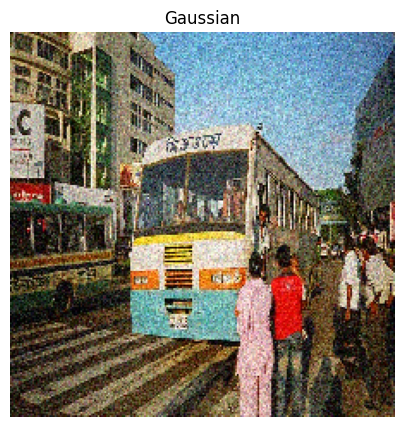

In [8]:
def plot_image(generator):
    """
    Estrae un'immagine random dal DirectoryIterator `generator`
    e la plotta con la sua label.
    """
    # 1) Scelgo un indice casuale tra 0 e generator.samples-1
    idx = random.randint(0, generator.samples - 1)
    
    # 2) Recupero il path assoluto dell'immagine
    img_path = generator.filepaths[idx]
    
    # 3) Carico e ridimensiono l'immagine secondo target_size del generatore
    img = load_img(img_path, target_size=generator.target_size)
    img_arr = img_to_array(img) / 255.0   # normalizzo [0,1]
    
    # 4) Trovo la label corrispondente
    class_idx = generator.classes[idx]
    inv_map = {v: k for k, v in generator.class_indices.items()}
    label = inv_map[class_idx]
    
    # 5) Plotto
    plt.figure(figsize=(5,5))
    plt.imshow(img_arr)
    plt.title(label)
    plt.axis('off')
    plt.show()

plot_image(train_gen)

In [9]:
model = models.Sequential()
model.add(layers.Input(shape=(IMG_H, IMG_W, 3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_gen.class_indices), activation='softmax'))

In [136]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_H, IMG_W, 3)
)

# Transfer Learning: all original layers are frozen
for layer in base_model.layers:
    layer.trainable = True


model = Sequential([
    base_model, # tutto il backbone freezato InceptionV3
    layers.GlobalAveragePooling2D(name='avg_pool'), # riduzione parametri
    layers.Dense(128, activation='relu', name='fc1'),
    layers.Dropout(0.5, name='dropout'), # cerco di evitare overfitting
    layers.Dense(len(train_gen.class_indices), activation='softmax', name='predictions')
])

In [10]:
# Imposto batch_size per ridurre overhead cpu-gpu (cpu è il bottleneck)
BATCH = 16
train_gen.batch_size = BATCH
val_gen.batch_size   = BATCH
test_gen.batch_size  = BATCH

steps_per_epoch    = train_gen.samples // BATCH
validation_steps  = val_gen.samples // BATCH

In [11]:
# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [164]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 26, 26, 128)     

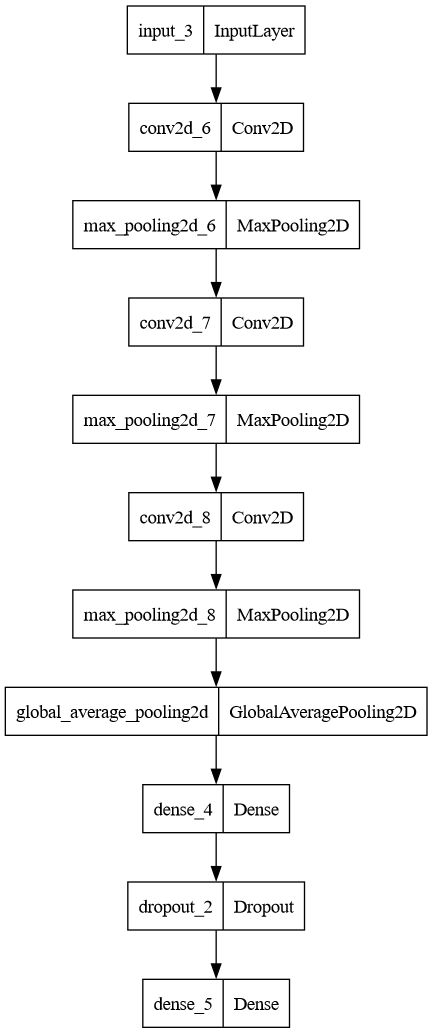

In [41]:
plot_model(model)

In [12]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, # mi fermo se per 5 epochs non miglioro
    restore_best_weights=True # ripristino pesi migliori (prima di overfittare)
)

mc = ModelCheckpoint(
    'best_model_GAP.h5', 
    monitor='val_loss',
    save_best_only=True # salvo solo il modello con val_loss migliore
)

In [123]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("🖥️ GPU rilevate:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ La GPU è attiva e disponibile! 🚀")
else:
    print("❌ Nessuna GPU disponibile.")


✅ TensorFlow version: 2.10.1
🖥️ GPU rilevate: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ La GPU è attiva e disponibile! 🚀


In [13]:
# Training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch, # numero batch in una epoch di training
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[es, mc], # Early Stopping + best model checkpoint
    workers=4, # numero thread in parallelo
    use_multiprocessing=False, # non si può
    max_queue_size=10
)

Epoch 1/100
437/437 [==============================] - 41s 79ms/step - loss: 1.2215 - accuracy: 0.4039 - val_loss: 0.7873 - val_accuracy: 0.5981
Epoch 2/100
437/437 [==============================] - 22s 50ms/step - loss: 0.8226 - accuracy: 0.5833 - val_loss: 0.6884 - val_accuracy: 0.6458
Epoch 3/100
437/437 [==============================] - 19s 43ms/step - loss: 0.7551 - accuracy: 0.6037 - val_loss: 0.8107 - val_accuracy: 0.6284
Epoch 4/100
437/437 [==============================] - 20s 45ms/step - loss: 0.7693 - accuracy: 0.6101 - val_loss: 0.6997 - val_accuracy: 0.6391
Epoch 5/100
437/437 [==============================] - 20s 45ms/step - loss: 0.7073 - accuracy: 0.6289 - val_loss: 0.6740 - val_accuracy: 0.6405
Epoch 6/100
437/437 [==============================] - 20s 45ms/step - loss: 0.7024 - accuracy: 0.6362 - val_loss: 0.6610 - val_accuracy: 0.6250
Epoch 7/100
437/437 [==============================] - 20s 45ms/step - loss: 0.7007 - accuracy: 0.6362 - val_loss: 0.6653 - val_ac

In [22]:
model.save('final_model.h5')

In [22]:
model = load_model('2000_GAP_0.001_96%.h5')

45% accuracy con 100 immagini per classe

64.6% accuracy con 2000 immagini per classe

65.8% accuracy con GAP

40% accuracy con InceptionV3 transfer learning

57% accuracy con InceptionV3 fine tuning su 100 layers

88-93% con GAP e alpha = 0.0001 (114 epochs)

96% con GAP, alpha=0.001 (28 epochs), 20s per epoch, batch = 16

In [23]:
test_loss, test_acc = model.evaluate(test_gen)

94/94 [==============================] - 4s 44ms/step - loss: 0.1022 - accuracy: 0.9653


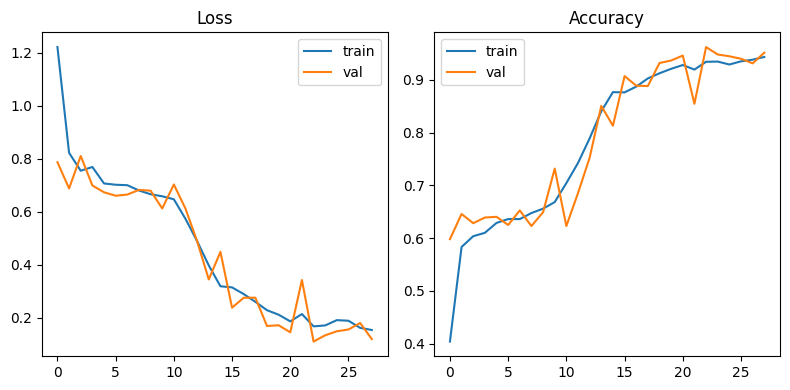

In [15]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 432ms/step


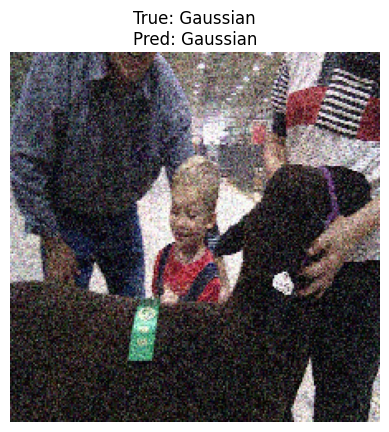

In [16]:
def show_random_prediction_tf(model, test_gen):
    """
    Seleziona un'immagine a caso dal test_gen di Keras, mostra l'immagine,
    la label effettiva e quella predetta dal modello.
    """
    # Costruisci lista di class names ordinata per indice
    class_indices = test_gen.class_indices
    class_names = [None] * len(class_indices)
    for cls, idx in class_indices.items():
        class_names[idx] = cls

    # Pesca un batch casuale
    total_batches = len(test_gen)
    batch_idx = random.randrange(total_batches)
    x_batch, y_batch = test_gen[batch_idx]

    # Pesca un campione casuale all'interno del batch
    sample_idx = random.randrange(x_batch.shape[0])
    img = x_batch[sample_idx]
    true_idx = np.argmax(y_batch[sample_idx])

    # Predizione
    preds = model.predict(img[np.newaxis, ...])
    pred_idx = np.argmax(preds[0])

    # Visualizza
    plt.imshow(img)
    plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}")
    plt.axis('off')
    plt.show()

# Esempio di utilizzo:
show_random_prediction_tf(model, test_gen)

In [17]:
pred_probs = model.predict(test_gen, verbose=1)

94/94 [==============================] - 4s 45ms/step


In [18]:
y_pred = np.argmax(pred_probs, axis=1) # y predicted
y_true = test_gen.classes # y actual

In [19]:
class_indices = test_gen.class_indices
class_names = [None] * len(class_indices)
for cls, idx in class_indices.items():
    class_names[idx] = cls

print(class_names)

['Erlang', 'Gaussian', 'Original', 'Salt & Pepper', 'Uniform']


In [20]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

               precision    recall  f1-score   support

       Erlang       0.96      0.98      0.97       300
     Gaussian       0.91      0.95      0.93       300
     Original       0.99      0.99      0.99       300
Salt & Pepper       1.00      1.00      1.00       300
      Uniform       0.96      0.90      0.93       300

     accuracy                           0.97      1500
    macro avg       0.97      0.97      0.97      1500
 weighted avg       0.97      0.97      0.97      1500



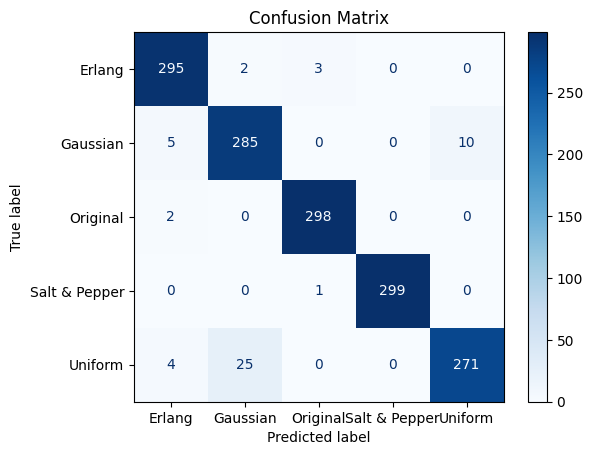

In [21]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
# PROBLEMA: il modello predice "Uniform" troppo spesso (anche se il rumore è Gaussian o Erlang)